In [6]:
pip install PyPDF2

In [7]:
# !pip install --upgrade scikit-learn

In [8]:
import sklearn
print(sklearn.__version__)

1.5.2


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Task 1b: Implement code to build the Term-document Matrix

In [10]:
import PyPDF2

#Extracting
def extract_text_from_pdf(pdf_file):
    text = ""
    with open(pdf_file, 'rb') as file:
        reader = PyPDF2.PdfReader(file)  # Use PdfReader instead of PdfFileReader
        for page_num in range(len(reader.pages)):  # reader.pages gives a list of pages
            page = reader.pages[page_num]
            text += page.extract_text()
    return text

book1 = extract_text_from_pdf("/content/drive/MyDrive/NLP/1.-Harry-Potter-and-the-Philosophers-Stone.pdf")
book2 = extract_text_from_pdf("/content/drive/MyDrive/NLP/2.-Harry-Potter-and-the-Chamber-of-Secrets.pdf")
book3 = extract_text_from_pdf("/content/drive/MyDrive/NLP/3.-Harry-Potter-and-the-Prisoner-of-Azkaban.pdf")
book4 = extract_text_from_pdf("/content/drive/MyDrive/NLP/4.-Harry-Potter-and-the-Goblet.pdf")

In [11]:
# Text Preprocessing:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return tokens

processed_text1 = preprocess_text(book1)
processed_text2 = preprocess_text(book2)
processed_text3 = preprocess_text(book3)
processed_text4 = preprocess_text(book4)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
import time
from sklearn.feature_extraction.text import CountVectorizer

def ensure_string(text):
    if isinstance(text, list):
        return ' '.join(text)

def build_term_document_matrix(documents):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(documents)
    return X, vectorizer.get_feature_names_out()

documents = [
    ensure_string(processed_text1),
    ensure_string(processed_text2),
    ensure_string(processed_text3),
    ensure_string(processed_text4)
]

start_time = time.time()

term_document_matrix, terms = build_term_document_matrix(documents)

execution_time = time.time() - start_time


print("Term-Document Matrix (Raw Frequency):")
print(term_document_matrix.toarray())

print("\nTerms (Features):")
print(terms)

print(f"\nExecution Time: {execution_time} seconds")

Term-Document Matrix (Raw Frequency):
[[ 1  1  1 ...  2  0  1]
 [ 1  1  1 ...  0  0  0]
 [ 1  1  1 ...  3  0  0]
 [ 1  1  1 ... 11  1  3]]

Terms (Features):
['10' '100' '101' ... 'zooming' 'éclair' 'éclairs']

Execution Time: 0.6441917419433594 seconds


# Task 1c: Compute Similarities Using Euclidean Distance and Cosine Similarity

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(term_document_matrix)
print("Cosine Similarity Matrix:\n", cosine_sim)


Cosine Similarity Matrix:
 [[1.         0.94329679 0.9416178  0.93467331]
 [0.94329679 1.         0.95078986 0.95214857]
 [0.9416178  0.95078986 1.         0.94577085]
 [0.93467331 0.95214857 0.94577085 1.        ]]


Cosine similarity will indicate how similar the books are based on the angle between their term vectors. Values closer to 1 indicate more similarity.

# Task 1d: Select representative words and compute reduced embedding.

In [15]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD

# Combine the processed texts into a list
documents1 = [' '.join(processed_text1),
             ' '.join(processed_text2),
             ' '.join(processed_text3),
             ' '.join(processed_text4)]


representative_words = [
    'Harry', 'Hogwarts', 'magic', 'wand',
    'Voldemort', 'wizard', 'spell', 'Ron', 'Slytherin'
]

def build_selected_term_document_matrix(documents, selected_words):
    vectorizer = CountVectorizer(vocabulary=selected_words)
    X = vectorizer.fit_transform(documents)
    return X, vectorizer.get_feature_names_out()

selected_term_document_matrix, selected_terms = build_selected_term_document_matrix(documents, representative_words)

print("Term-Document Matrix for selected representative words:")
print(pd.DataFrame(selected_term_document_matrix.toarray(), columns=selected_terms))


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:1364: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


Term-Document Matrix for selected representative words:
   Harry  Hogwarts  magic  wand  Voldemort  wizard  spell  Ron  Slytherin
0      0         0     46    60          0      42     14    0          0
1      0         0     52   105          0      47      6    0          0
2      0         0     60   113          0      39      6    0          0
3      0         0     85   272          0      83     35    0          0


In [16]:
cosine_sim = cosine_similarity(selected_term_document_matrix)
print("Cosine Similarity Matrix:\n", pd.DataFrame(cosine_sim, columns=["Book 1", "Book 2", "Book 3", "Book 4"], index=["Book 1", "Book 2", "Book 3", "Book 4"]))

Cosine Similarity Matrix:
           Book 1    Book 2    Book 3    Book 4
Book 1  1.000000  0.970810  0.960078  0.924430
Book 2  0.970810  1.000000  0.995989  0.981929
Book 3  0.960078  0.995989  1.000000  0.981706
Book 4  0.924430  0.981929  0.981706  1.000000


By focusing on key words related to the Harry Potter universe, overall the similarity scores will increase, as the key words will represent the core themes of each book more accurately than the full vocabulary.

In [17]:
from sklearn.decomposition import TruncatedSVD
import pandas as pd

def compute_reduced_embedding(term_document_matrix, n_components=2):
    svd = TruncatedSVD(n_components=n_components)
    reduced_matrix = svd.fit_transform(term_document_matrix)
    return reduced_matrix

reduced_embedding = compute_reduced_embedding(selected_term_document_matrix)

print("TruncatedSVD Reduced Embedding:")
print(pd.DataFrame(reduced_embedding, columns=[f'Component {i+1}' for i in range(reduced_embedding.shape[1])]))


TruncatedSVD Reduced Embedding:
   Component 1  Component 2
0    82.839655    26.913382
1   125.388551    14.723218
2   132.735560    13.444964
3   298.203681   -19.651813


In [18]:
from sklearn.decomposition import PCA

# Step 5: Compute the reduced embedding using PCA
def compute_pca_embedding(term_document_matrix, n_components=2):
    pca = PCA(n_components=n_components)
    pca_reduced_matrix = pca.fit_transform(term_document_matrix.toarray())
    return pca_reduced_matrix

# Compute the PCA reduced embedding
pca_reduced_embedding = compute_pca_embedding(selected_term_document_matrix)

# Display the PCA reduced embedding
print("PCA Reduced Embedding:")
print(pd.DataFrame(pca_reduced_embedding, columns=[f'Component {i+1}' for i in range(pca_reduced_embedding.shape[1])]))


PCA Reduced Embedding:
   Component 1  Component 2
0   -78.974195    10.024436
1   -34.890374    -2.421648
2   -27.466978   -10.555147
3   141.331546     2.952359


# Task 3: Visualize Task 1

#3.1 Visualize Task 1b

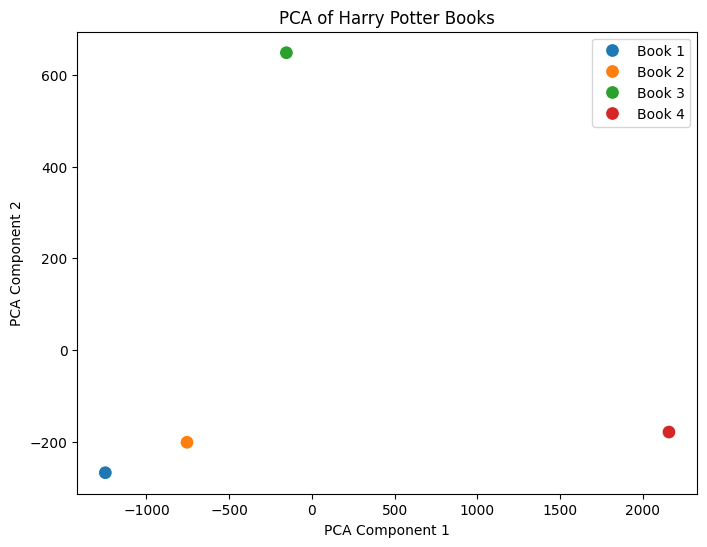

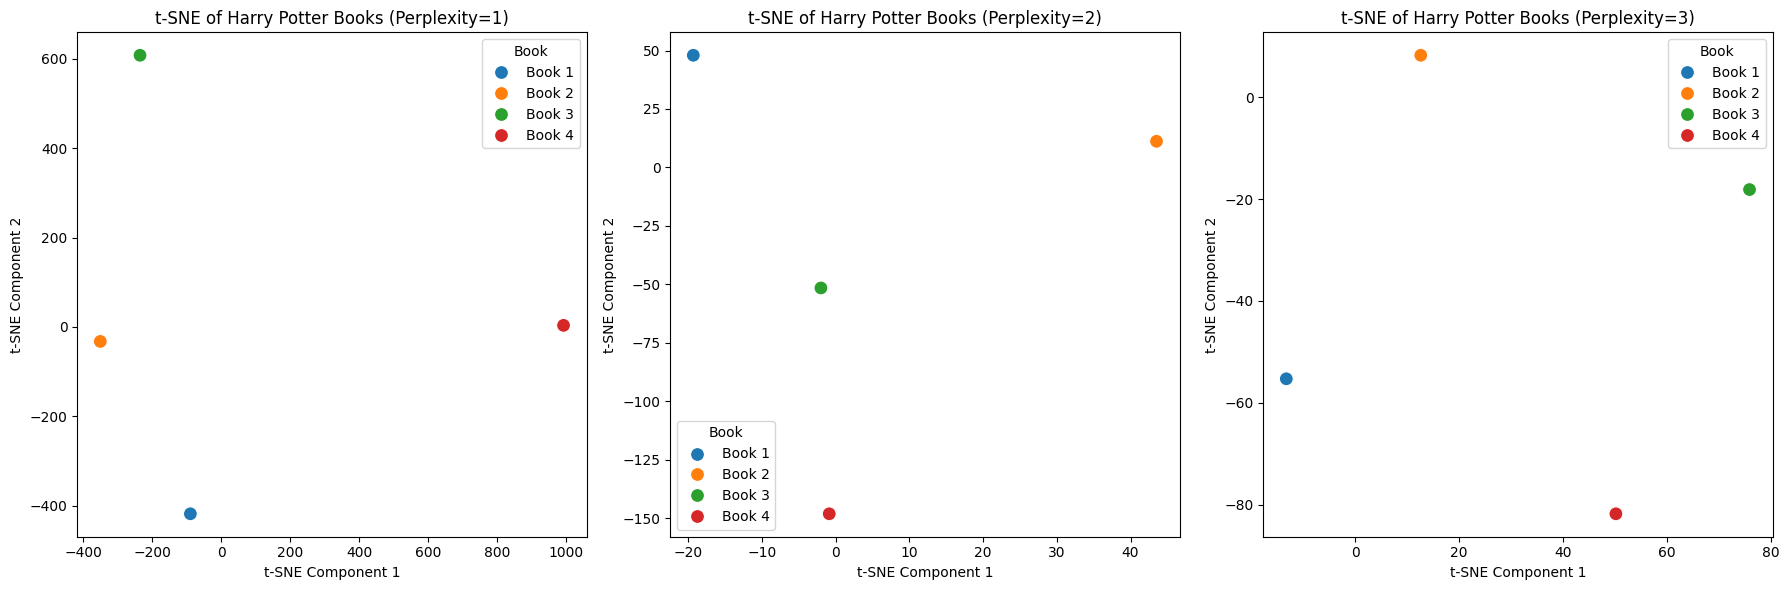

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
pca = PCA(n_components=2)
pca_result = pca.fit_transform(term_document_matrix.toarray())  # Convert sparse matrix to dense

# Create DataFrame for PCA results
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['Book'] = [f'Book {i+1}' for i in range(len(documents))]

# Plot PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Book', s=100)
plt.title('PCA of Harry Potter Books')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
# plt.xticks([])
# plt.yticks([])
plt.legend()
plt.show()

# Create and plot t-SNE results for different perplexities
perplexities = [1, 2, 3]
plt.figure(figsize=(18, 6))

for i, perplexity in enumerate(perplexities, 1):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)  # Adjust perplexity
    tsne_result = tsne.fit_transform(term_document_matrix.toarray())

    # Create DataFrame for t-SNE results
    tsne_df = pd.DataFrame(tsne_result, columns=['tSNE1', 'tSNE2'])
    tsne_df['Book'] = [f'Book {j+1}' for j in range(len(documents))]

    # Plot t-SNE results
    plt.subplot(1, 3, i)
    sns.scatterplot(data=tsne_df, x='tSNE1', y='tSNE2', hue='Book', s=100)
    plt.title(f't-SNE of Harry Potter Books (Perplexity={perplexity})')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    # plt.xticks([])
    # plt.yticks([])

plt.tight_layout()
plt.show()

#3.2 Visualize Task 1d

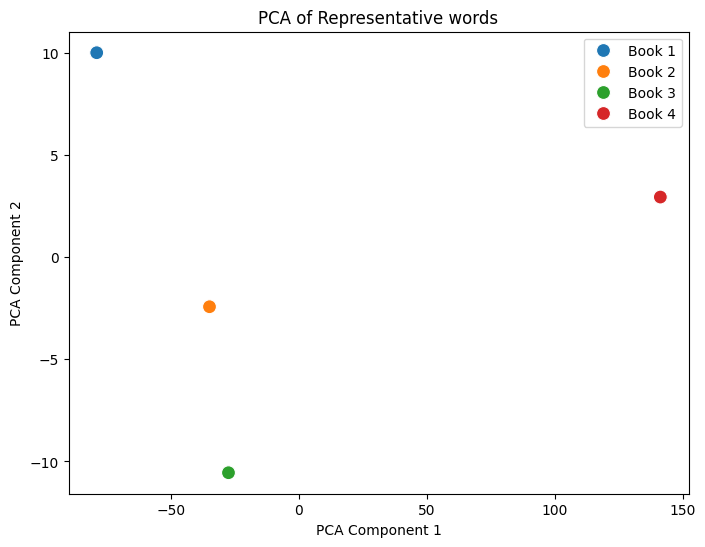

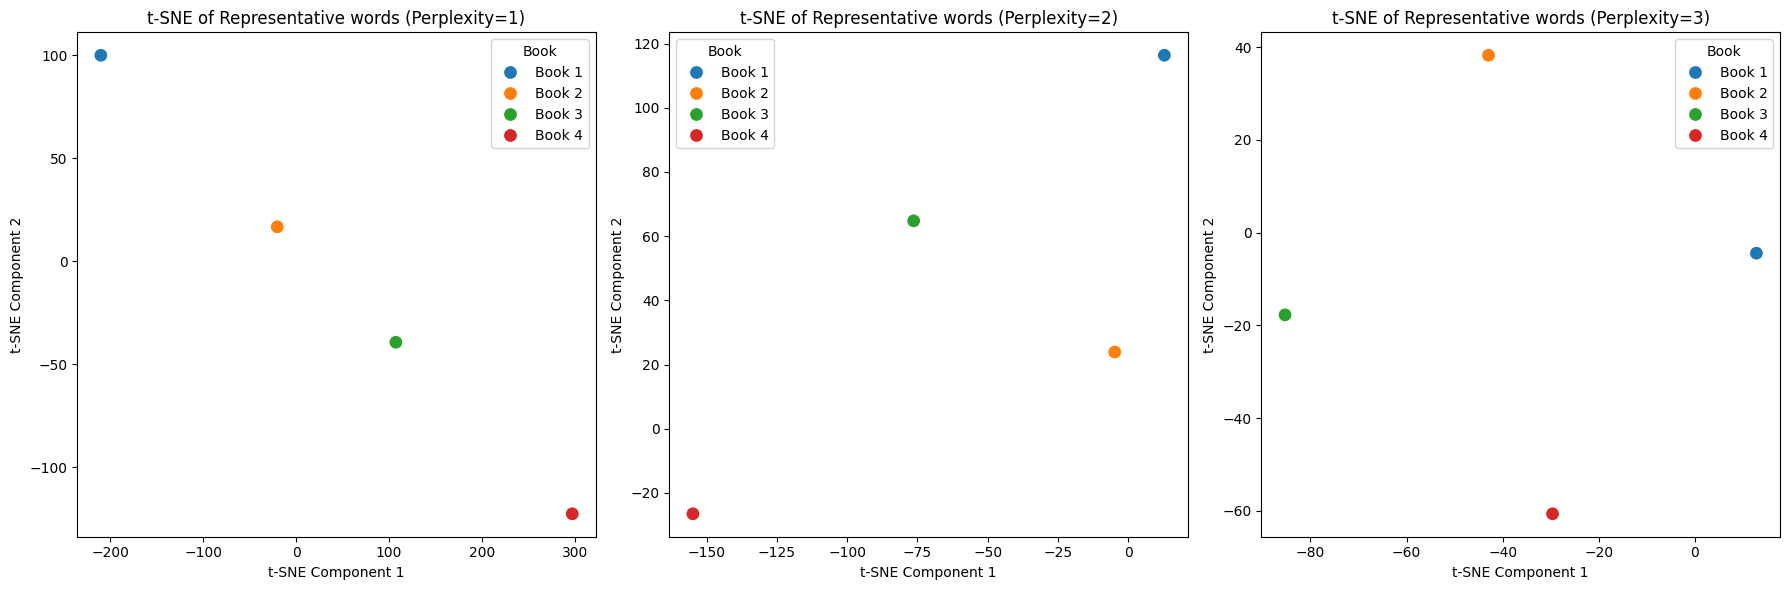

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
pca = PCA(n_components=2)
pca_result1 = pca.fit_transform(selected_term_document_matrix.toarray())  # Convert sparse matrix to dense

# Create DataFrame for PCA results
pca_df = pd.DataFrame(pca_result1, columns=['PCA1', 'PCA2'])
pca_df['Book'] = [f'Book {i+1}' for i in range(len(documents))]

# Plot PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Book', s=100)
plt.title('PCA of Representative words')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
# plt.xticks([])
# plt.yticks([])
plt.legend()
plt.show()

# Create and plot t-SNE results for different perplexities
perplexities = [1, 2, 3]
plt.figure(figsize=(18, 6))

for i, perplexity in enumerate(perplexities, 1):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)  # Adjust perplexity
    tsne_result = tsne.fit_transform(selected_term_document_matrix.toarray())

    # Create DataFrame for t-SNE results
    tsne_df = pd.DataFrame(tsne_result, columns=['tSNE1', 'tSNE2'])
    tsne_df['Book'] = [f'Book {j+1}' for j in range(len(documents))]

    # Plot t-SNE results
    plt.subplot(1, 3, i)
    sns.scatterplot(data=tsne_df, x='tSNE1', y='tSNE2', hue='Book', s=100)
    plt.title(f't-SNE of Representative words (Perplexity={perplexity})')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    # plt.xticks([])
    # plt.yticks([])

plt.tight_layout()
plt.show()

I think Truncated SVD is a more preferred choice in NLP than PCA because Truncated SVD is specifically designed to work efficiently with large data sets and sparse matrices, just like document term matrices, and no need for data centering too, while PCA can struggle with them.

# Task 7: Derive the formula for Conditional Entropy

pls give me more time :(